### Parameters
- Optimizer - Adam
- Loss function - Categorical Crossentropy
- Input layer - 4 values
- Output layer - 3 categories
- Hidden layer - 1 layer with 16 nodes
- Epochs - 100
- Batch size - 10

In [1]:
# Importing necessery libraries
%matplotlib inline
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import keras
from keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
# Reading out data
df = pd.read_csv('../data/file20000.csv')
df.head()

,Unnamed: 0,0,1,2,3,4
0,0,0,7,7,7,1
1,1,0,7,7,7,1
2,2,0,7,7,6,1
3,3,0,7,7,5,1
4,4,0,6,7,4,2


In [3]:
# Removing redundant column Unnamed: 0
df = df.drop('Unnamed: 0', 1)

### From the table above we see that the column ```Unnamed: 0``` is redundant, as it shows the count of rows which can be found in pandas table whenever printing a dataframe.

### The headers of columns are meaningless. They should be renamed to the following:
- First column - My_position,
- Second column - Left_line,
- Third column - Mid_line,
- Fourth column - Right_line,
- Fifth column - Action

In [4]:
# Renaming headers of columns
df.rename(columns={'0': 'My_position', '1': 'Left_line', '2': 'Mid_line', '3': 'Right_line', '4': 'Action'}, inplace=True)
df.head()

,My_position,Left_line,Mid_line,Right_line,Action
0,0,7,7,7,1
1,0,7,7,7,1
2,0,7,7,6,1
3,0,7,7,5,1
4,0,6,7,4,2


### ```My_position``` and ```Action``` have integer values from [ 0 to 2 ]
### ```Left_line```, ```Middle_line``` and ```Right_line``` have integer values from [ 0 to 8 ]

In [5]:
# Checking data insights
df.describe()

,My_position,Left_line,Mid_line,Right_line,Action
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.941700,3.502200,3.327200,3.418050,1.000100
std,0.786977,2.645646,2.603282,2.618764,0.447895
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,3.000000,3.000000,3.000000,1.000000
75%,2.000000,7.000000,6.000000,6.000000,1.000000
max,2.000000,7.000000,7.000000,7.000000,2.000000


### From the table above we can assume the following:
### ```Mean``` values of all columns are acceptable
- For <b>My_position</b> and <b>Action</b> columns the mean is expected to be around 1
- For <b>Left_line</b>, <b>Mid_line</b>, <b>Right_line</b> columns the mean is expected to be around 3.5

### ```Std``` values of all columns are acceptable, although ```Action``` column seems a bit off
- For <b>My_position</b> and <b>Action</b> columns the std is expected to be around 1
- For <b>Left_line</b>, <b>Mid_line</b>, <b>Right_line</b> columns the std is expected to be around 2 - 3

### ```Min``` values of all columns are correct
- For <b>My_position</b> and <b>Action</b> columns the min has to be equal to 0
- For <b>Left_line</b>, <b>Mid_line</b>, <b>Right_line</b> columns the min has to be equal to 0

### ```25%```, ```50%```, ```75%``` values of all columns are acceptable
- For <b>My_position</b> and <b>Action</b> columns the values are expected to be 0, 1, 2 respectively
- For <b>Left_line</b>, <b>Mid_line</b>, <b>Right_line</b> columns the values are expected to be 1-2, 3-4, 5-6 respectively

### ```Max``` values of all columns are correct
- For <b>My_position</b> and <b>Action</b> columns the max has to be equal to 2
- For <b>Left_line</b>, <b>Mid_line</b>, <b>Right_line</b> columns the max has to be equal to 7

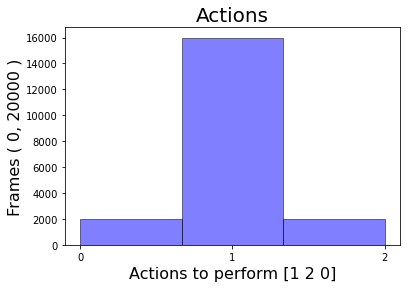

In [6]:
# Build up a histogram of Actions column to find out why std is small
# Action types are as follows: Left - 0, Stay - 1, Right -2
column = df['Action']
# Set a title for histogram
plt.title('Actions', fontsize=20)
# Find out amount of unique actions
unique_actions = len(column.unique())
# Set X axis to have only values of the actions that exist in the column
plt.xticks(column.unique())
# Show actions that can be performed on the X axiss
plt.xlabel('Actions to perform ' + str(column.unique()), fontsize=16)
# Show total amount of values the column has
plt.ylabel('Frames ( 0, ' + str(len(df['Action'])) + ' )', fontsize=16)
# Set the histogram with above properties
plt.hist(column, unique_actions, facecolor='blue', ec='black', alpha=0.5)
# Show the histogram
plt.show()

### From the histogram above we can see that most of the actions are 1 which means stay
This makes sence, since every 2 frames a new car appears and when it does it has to choose only 1 road line to appear at. Every batch 6 of cells (3 lines in 2 steps) had only 1 car on it, which let my car stand most of the time

In [7]:
# See amount of unique values of Action column
df['Action'].value_counts()

1    15988
2     2007
0     2005
Name: Action, dtype: int64

### If we train our model with this data, it will assume that standing is the best choice in most of the cases. There are several ways to solve this problem. Some of them are listed below:
- We need to train some more data saved in another file and add from that to this file new rows with actions other than 1 to this dataset
- We need to modify the car appearing function in the game that will make sure cars do not appear after one another
- Remove some of the results from this dataframe where action is 1


#### We will take the last choice and remove some portion of data that has action 1
#### Find out the portion to be removed from ~16k down to ~2k. It makes 12.5%
#### We will take random number between 0 and 125 and if it is greater than 13 we will remove the Action

In [8]:
# Set 87.5% of the actions that has value 1 to NaN, so that later they can be removed from db
for i in range(len(df['Action'])):
    if df['Action'][i] == 1:
        a = random.randint(0,100)
        if a > 12:
            df['Action'][i] = None

In [9]:
# Remove the rows that have NaN as a result of Action column
df = df.dropna()

In [10]:
# Check the unique value counts in the Action column
df['Action'].value_counts()

1.0    2147
2.0    2007
0.0    2005
Name: Action, dtype: int64

### After reducing Action column with specific value 1 by 87.5% we have normalized our dataset. This sort of action will lead to a better performance during training the model
### Now it is time to separate input data and labels and split it into train and test datasets

In [11]:
# Remove Action column and assign the rest to the new variable of input data
input_data = df.drop('Action',1)
input_data.head()

,My_position,Left_line,Mid_line,Right_line
4,0,6,7,4
7,1,3,7,1
8,1,2,6,0
10,1,0,4,2
11,1,7,3,1


In [12]:
# Take only Action column to represent labels for the prediction
output_data = df['Action']

In [13]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.20, random_state=7)

In [14]:
# Prepare train and test labels into categorical model by 1 hot encoding it
y_train = keras.utils.to_categorical(y_train, 3)
y_test = keras.utils.to_categorical(y_test, 3)

In [15]:
# Define the keras model
model = Sequential()
model.add(Dense(16, input_shape=(4, )))
model.add(Activation('relu'))
model.add(Dense(16, input_shape=(16, )))
model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('softmax'))

In [16]:
# Compile the defined model
model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [17]:
# Train the keras model with the train dataset
model.fit(X_train, y_train, epochs=50, batch_size=10)

Epoch 1/50
493/493 [==============================] - 0s 756us/step - loss: 0.8605 - accuracy: 0.5417
Epoch 2/50
493/493 [==============================] - 0s 788us/step - loss: 0.5248 - accuracy: 0.7912
Epoch 3/50
493/493 [==============================] - 0s 863us/step - loss: 0.3214 - accuracy: 0.9271
Epoch 4/50
493/493 [==============================] - 0s 748us/step - loss: 0.2235 - accuracy: 0.9627
Epoch 5/50
493/493 [==============================] - 0s 830us/step - loss: 0.1752 - accuracy: 0.9714
Epoch 6/50
493/493 [==============================] - 0s 913us/step - loss: 0.1454 - accuracy: 0.9734
Epoch 7/50
493/493 [==============================] - 0s 744us/step - loss: 0.1103 - accuracy: 0.9781
Epoch 8/50
493/493 [==============================] - 0s 786us/step - loss: 0.0855 - accuracy: 0.9852
Epoch 9/50
493/493 [==============================] - 0s 798us/step - loss: 0.0713 - accuracy: 0.9858
Epoch 10/50
493/493 [==============================] - 0s 859us/step - loss: 0.061

In [18]:
# Evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

39/39 [==============================] - 0s 801us/step - loss: 0.0099 - accuracy: 0.9992
Accuracy: 99.92


In [19]:
# Create a HDF5 file to save the model
model.save('../models/categorical_crossentropy.h5')